In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline

In [ ]:
od.download('https://www.kaggle.com/paultimothymooney/blood-cells')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: 
Your Kaggle username: maniyarsuyash
Your Kaggle Key: ··········


100%|██████████| 108M/108M [00:03<00:00, 29.8MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd blood-cells

/content/blood-cells


In [ ]:
%cd dataset2-master/dataset2-master/images

/content/blood-cells/dataset2-master/dataset2-master/images


In [ ]:
DATA_DIR = '/content/blood-cells/dataset2-master/dataset2-master'


TRAIN_DIR = DATA_DIR + '/images/TRAIN'                           # Contains training images
TEST_DIR = DATA_DIR + '/images/TEST'                             # Contains test images

LABELS_CSV = DATA_DIR + '/labels.csv'                       # Contains real labels for training images

In [ ]:
%cd ..

/content/blood-cells/dataset2-master/dataset2-master


In [ ]:
df = pd.read_csv("labels.csv") 

In [ ]:
df

,Unnamed: 0,Image,Category
0,NaN,0,NEUTROPHIL
1,NaN,1,NEUTROPHIL
2,NaN,2,NEUTROPHIL
3,NaN,3,NEUTROPHIL
4,NaN,4,NEUTROPHIL
...,...,...,...
406,NaN,406,NaN
407,NaN,407,NEUTROPHIL
408,NaN,408,NEUTROPHIL
409,NaN,409,NEUTROPHIL


In [ ]:
!ls "{TRAIN_DIR}" | head

EOSINOPHIL
LYMPHOCYTE
MONOCYTE
NEUTROPHIL


In [ ]:
!ls "{TRAIN_DIR}/EOSINOPHIL" | head

_0_1169.jpeg
_0_1414.jpeg
_0_207.jpeg
_0_2142.jpeg
_0_2370.jpeg
_0_3072.jpeg
_0_4431.jpeg
_0_4480.jpeg
_0_4574.jpeg
_0_4747.jpeg


In [ ]:
all_eosinophils=os.listdir(TRAIN_DIR + "/EOSINOPHIL")
len(all_eosinophils)

2497

In [ ]:
PROCESSED_DATA_DIR = '/content/blood-cells'
PROCESSED_TRAIN_DIR = PROCESSED_DATA_DIR + '/train'
PROCESSED_TEST_DIR = PROCESSED_DATA_DIR + '/test'
TRAIN_CSV = PROCESSED_DATA_DIR + '/train_labels.csv'
TEST_CSV = PROCESSED_DATA_DIR + '/test_labels.csv'

In [ ]:
def get_labels(folder_path, filename_to_save=None):
  ''' Gets folder path and returns labels dataframe '''
  labels = np.column_stack(([],[],[]))
  dirnames = os.listdir(folder_path)
  for i, dirname in enumerate(dirnames):
    if os.path.isdir(os.path.join(folder_path, dirname)):
      files_list = os.listdir(os.path.join(folder_path, dirname))      
      labels = np.vstack((labels, np.column_stack((([dirname] * len(files_list)),([i] * len(files_list)), files_list))))
  labels_df = pd.DataFrame(labels, columns = ['text_label', 'num_label', 'img_name'])
  if filename_to_save:
    labels_df.to_csv(filename_to_save)
  return labels_df

In [ ]:
train_labels = get_labels(TRAIN_DIR, TRAIN_CSV)

In [ ]:
test_labels = get_labels(TEST_DIR, TEST_CSV)

In [ ]:
lab_test = pd.DataFrame(test_labels.groupby(['text_label', 'num_label']).count())

In [ ]:
lab = pd.DataFrame(train_labels.groupby(['text_label', 'num_label']).count())

In [ ]:
labels_dict = {
    0: 'MONOCYTE',
    1: 'EOSINOPHIL',
    2: 'LYMPHOCYTE',
    3: 'NEUTROPHIL',    
}

In [ ]:
import shutil

def move_files(folder_path, folder):
  if not os.path.exists(folder):
    os.makedirs(folder)
  dirnames = os.listdir(folder_path)
  for i, dirname in enumerate(dirnames):
    if os.path.isdir(os.path.join(folder_path, dirname)):
      files_list = os.listdir(os.path.join(folder_path, dirname))
      for item in files_list:
          shutil.move(os.path.join(folder_path, dirname, item), os.path.join(folder, item))
  print(len(os.listdir(folder)), 'files moved.')

In [ ]:
move_files(TRAIN_DIR, PROCESSED_TRAIN_DIR)


9893 files moved.


In [ ]:
duplicated_img_name = list(train_labels[train_labels.img_name.duplicated()]['img_name'])

In [ ]:
removed_df = train_labels[train_labels.img_name.isin(duplicated_img_name)]

In [ ]:
def clean_data(img_dir, df, df_csv, removed_img_dir, removed_file):
  if not os.path.exists(removed_img_dir):
    os.makedirs(removed_img_dir)
  duplicated_img_list = list(df[df.img_name.duplicated()]['img_name'])
  removed_df = df[df.img_name.isin(duplicated_img_list)]
  removed_df.to_csv(removed_file)
  print(removed_df.shape[0], 'ambigous items moved to', removed_file)
  df.drop(index = df.index[df.img_name.isin(duplicated_img_list)], axis = 0, inplace = True)
  df.to_csv(df_csv)
  print('Now shape of dataframe', df.shape)
  
  files_list = os.listdir(img_dir)
  for item in files_list:
    if item in duplicated_img_list:
      shutil.move(os.path.join(img_dir, item), os.path.join(removed_img_dir, item))
  print(len(os.listdir(removed_img_dir)), 'moved to', removed_img_dir)

In [ ]:
clean_data(PROCESSED_TRAIN_DIR, train_labels, TRAIN_CSV, PROCESSED_DATA_DIR + '/removed_train', PROCESSED_DATA_DIR + '/removed_train.csv')

128 ambigous items moved to /content/blood-cells/removed_train.csv
Now shape of dataframe (9829, 3)
64 moved to /content/blood-cells/removed_train


In [ ]:
assert(len(os.listdir(PROCESSED_TRAIN_DIR)) == train_labels.shape[0])

In [ ]:
move_files(TEST_DIR, PROCESSED_TEST_DIR)

2476 files moved.


In [ ]:
duplicated_test_img_name = test_labels[test_labels.img_name.duplicated()]['img_name']


In [ ]:
clean_data(PROCESSED_TEST_DIR, test_labels, TEST_CSV, PROCESSED_DATA_DIR + '/removed_test', PROCESSED_DATA_DIR + '/removed_test.csv')

22 ambigous items moved to /content/blood-cells/removed_test.csv
Now shape of dataframe (2465, 3)
11 moved to /content/blood-cells/removed_test


In [ ]:
assert(len(os.listdir(PROCESSED_TEST_DIR)) == test_labels.shape[0])

In [ ]:
def encode_label(label):
    target = torch.zeros(4)
    target[int(label)] = 1.
    return target

def decode_target(target, text_labels=False):
    result = []
    i = np.argmax(target.numpy())
    if text_labels:
        result.append(labels_dict[i] + "(" + str(i) + ")")
    else:
        result.append(str(i))
    return ' '.join(result)

In [ ]:
class HumanBloodCellDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_name, img_label = row['img_name'], row['num_label']
        img_fname = self.root_dir + "/" + str(img_name)
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, encode_label(img_label) 

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = HumanBloodCellDataset(TRAIN_CSV, PROCESSED_TRAIN_DIR, transform=transform)

In [ ]:
dataset = HumanBloodCellDataset(TRAIN_CSV, PROCESSED_TRAIN_DIR, transform=transform)

In [ ]:
def show_sample(img, target, invert=False):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', decode_target(target, text_labels=True))

In [ ]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

In [ ]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(8847, 982)

In [ ]:
train_ds[4][0].shape

torch.Size([3, 240, 320])

In [ ]:
batch_size = 64

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

In [ ]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [ ]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.binary_cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_score']))

In [ ]:
class BloodCellCnnModel6CLBatchN(ImageClassificationBase):
    ''' Fork from  https://jovian.ai/aakashns/simple-cnn-starter but BatchNorm2d was added'''
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.AdaptiveAvgPool2d(1),

            nn.Flatten(), 
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),            
            nn.Linear(64, 4),
            nn.Sigmoid()
        )
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
class BloodCellCnnModelSqueezeNet1_1(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.squeezenet1_1(pretrained=True)
        # # Replace last layer
        self.network.classifier[1] = nn.Conv2d(512, 4, kernel_size=(1,1), stride=(1,1))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [ ]:
model2 = BloodCellCnnModel6CLBatchN()
model2

BloodCellCnnModel6CLBatchN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=T

In [ ]:
model3 = BloodCellCnnModelDenseNet121()
model3

In [ ]:
model4 = BloodCellCnnModelSqueezeNet1_1()
model4

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model2, device);

In [ ]:
def try_batch(dl):
    for images, labels in dl:
        print('images.shape:', images.shape)
        out = model2(images)
        print('out.shape:', out.shape)
        print('out[0]:', out[0])
        break

try_batch(train_dl)

images.shape: torch.Size([64, 3, 240, 320])
out.shape: torch.Size([64, 4])
out[0]: tensor([0.5571, 0.5071, 0.4147, 0.5298], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [ ]:
from tqdm.notebook import tqdm

In [ ]:
@torch.no_grad()
def evaluate(model2, val_loader):
    model2.eval()
    outputs = [model2.validation_step(batch) for batch in val_loader]
    return model2.validation_epoch_end(outputs)

def fit(epochs, lr, model2, train_loader, val_loader, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model2.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model2.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model2.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model2, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model2.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
def plot_losses(history, file_name=None):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');
    if file_name:
      plt.savefig(file_name)

In [ ]:
def plot_scores(history, file_name=None):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('Score vs. No. of epochs');
    if file_name:
      plt.savefig(file_name)

In [ ]:
history = [evaluate(model2, val_dl)]
history

[{'val_loss': 0.6600933074951172, 'val_score': 0.2561725974082947}]

In [ ]:
num_epochs = 1
opt_func = torch.optim.Adam
lr = 1e-2

In [ ]:
%%time
history += fit(num_epochs, lr, model2, train_dl, val_dl, opt_func)

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.2631, val_loss: 0.6411, val_score: 0.5054
CPU times: user 21.3 s, sys: 19.6 s, total: 40.9 s
Wall time: 1min


In [ ]:
%%time
num_epochs = 5
lr = 1e-3
history += fit(num_epochs, lr, model2, train_dl, val_dl, opt_func)

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.0755, val_loss: 0.0532, val_score: 0.9564


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.0377, val_loss: 0.0297, val_score: 0.9811


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.0228, val_loss: 0.0197, val_score: 0.9903


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.0192, val_loss: 0.0111, val_score: 0.9941


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.0147, val_loss: 0.0135, val_score: 0.9918
CPU times: user 1min 59s, sys: 1min 50s, total: 3min 50s
Wall time: 4min 56s


In [ ]:
%%time
# num_epochs = 3
# lr = 0.0005
# history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


In [ ]:
%%time
# num_epochs = 3
# lr = 0.0001
# history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.48 µs


In [ ]:
%%time
# num_epochs = 3
# lr = 0.00005
# history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 5.96 µs


In [ ]:
%%time
# num_epochs = 3
# lr = 0.00005
# history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 10.5 µs


In [ ]:
test_dataset = HumanBloodCellDataset(TEST_CSV, PROCESSED_TEST_DIR, transform=transform)

In [ ]:
test_dl = DeviceDataLoader(DataLoader(test_dataset, batch_size, num_workers=2, pin_memory=True), device)

In [ ]:
@torch.no_grad()
def predict_dl(dl, model2):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        probs = model2(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    return [decode_target(x) for x in batch_probs]

In [ ]:
test_preds = predict_dl(test_dl, model2)

  0%|          | 0/39 [00:00<?, ?it/s]

In [ ]:
test_labels['BloodCellCnnModel6CLBatchN_11epochs'] = test_preds

In [ ]:
test_labels.head()

,text_label,num_label,img_name,BloodCellCnnModel6CLBatchN_11epochs
0,LYMPHOCYTE,0,_5_2263.jpeg,0
1,LYMPHOCYTE,0,_0_4406.jpeg,0
2,LYMPHOCYTE,0,_1_7506.jpeg,0
3,LYMPHOCYTE,0,_0_6581.jpeg,0
4,LYMPHOCYTE,0,_4_2380.jpeg,0


In [ ]:
test_labels.to_csv(TEST_CSV)

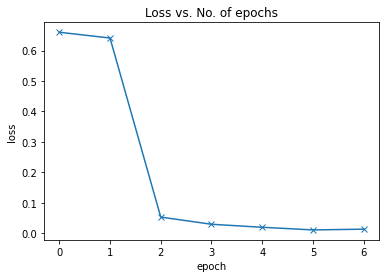

In [ ]:
plot_losses(history, DATA_DIR + '/plot_losses_BloodCellCnnModel6CLBatchN_11epochs.png')

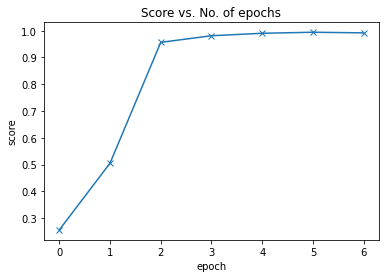

In [ ]:
plot_scores(history, DATA_DIR + '/plot_scores_CellCnnModel6CLBatchN_11epochs.png')

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
y_preds = [int(x) for x in test_preds]

In [ ]:
len(y_preds)

2465

In [ ]:
y_true = test_labels.num_label.astype(np.int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


In [ ]:
len(y_true)

2465

In [ ]:
df_report = pd.DataFrame(classification_report(y_true, y_preds, output_dict = True))
df_report

,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.996732,0.631463,0.899177,1.000000,0.843408,0.881843,0.880809
recall,0.996732,0.921348,0.708266,0.747145,0.843408,0.843373,0.843408
f1-score,0.996732,0.749347,0.792384,0.855275,0.843408,0.848435,0.847882
support,612.000000,623.000000,617.000000,613.000000,0.843408,2465.000000,2465.000000


In [ ]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

In [ ]:
cf_matrix=confusion_matrix(y_true,y_preds )

In [ ]:
cf_matrix

array([[610,   2,   0,   0],
       [  0, 574,  49,   0],
       [  2, 178, 437,   0],
       [  0, 155,   0, 458]])

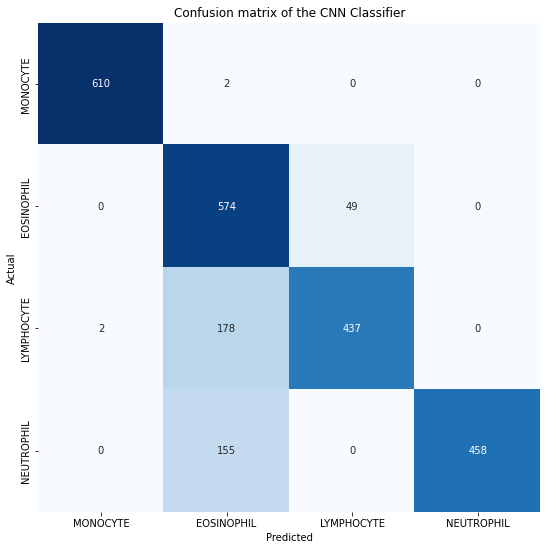

In [ ]:
labels = ['MONOCYTE','EOSINOPHIL','LYMPHOCYTE','NEUTROPHIL']
 

plt.figure(figsize=(9,9))
sns.heatmap(cf_matrix, cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix of the CNN Classifier')
plt.show()